In [117]:
from keras.applications.xception import Xception
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [118]:
base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [119]:
x = base_model.output
x = Flatten()(x)
x = Dense(4096, name='fc1')(x)
x = Dropout(0.2)(x)
x = Dense(4096, name='fc2')(x)
x = Dense(10, activation=None, name='predictions')(x)


model_final = Model(inputs=base_model.input, outputs=x)
#model_final.compile(loss="categorical_crossentropy", optimizer=optimizers.sgd(lr=0.0001, momentum=0.9), metrics=["accuracy"])
model_final.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=0.00001), metrics=["accuracy"])
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [124]:
weights_file = 'vgg16_clothing_classifier.h5'
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range =.2,
                                  zoom_range = .2,
                                  horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_data_dir = 'subset/train'
validation_data_dir = "subset/test"
nb_validation_samples = 1000
nb_train_samples = 5000
epochs = 10
batch_size = 16
img_width, img_height = 224, 224

train_generator = train_datagen.flow_from_directory(
                train_data_dir,
                target_size=(img_width, img_height),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

val_generator = val_datagen.flow_from_directory(
                                validation_data_dir,
                                target_size = (img_height, img_width),
                                batch_size=batch_size,
                                class_mode = "categorical")

checkpoint = ModelCheckpoint(weights_file, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [122]:
train_generator.class_indices

{'dress': 0,
 'jacket': 1,
 'jeans': 2,
 'outerwear': 3,
 'pants': 4,
 'shorts': 5,
 'skirts': 6,
 'sweaters': 7,
 'sweatshirt': 8,
 'tops': 9}

In [125]:
# Train the model 
history = model_final.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=nb_validation_samples//batch_size,
            verbose=1,
            workers=4,
            callbacks = [checkpoint, early])

Epoch 1/10
  2/312 [..............................] - ETA: 1:27:49 - loss: 6.8676 - acc: 0.0938    

KeyboardInterrupt: 

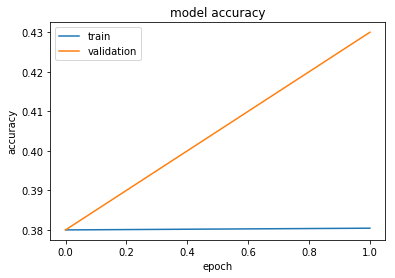

In [53]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [126]:
model_final.save_weights(weights_file)

In [127]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
def get_input(img_path):
    img = imread(img_path)
    img = resize(img, (224, 224), preserve_range=True).astype(np.float32)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def get_predictions(img_path, decode=True):
    input_ = get_input(img_path)
    out = model_final.predict(input_)
    if decode:
        return decode_predictions(out)
    else:
        return out

In [198]:
model_final.predict(get_input('data/train/sweatshirt/693270349.jpg'))

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[ 41.26117  , -38.70192  ,  34.237724 , -18.751616 ,  51.80874  ,
         -6.1047664, -37.319256 ,  18.213902 ,   9.048164 ,   8.462398 ]],
      dtype=float32)

In [155]:
def image_pre_process(img_file):
    img = imread(img_file)
    img = resize(img, (224, 224), preserve_range=True).astype(np.float32)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [208]:
image_pre_process('data/train/pants/202176513.jpg')

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[[[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        ...,

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,


In [204]:
img = image_pre_process('data/train/pants/202176513.jpg')

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [205]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())

In [206]:
predictions= model_final.predict(img)[0]
predictions = np.argmax(predictions,axis=-1)
predictions = label_map[predictions]
predictions

'pants'

In [207]:
train_generator.class_indices

{'dress': 0,
 'jacket': 1,
 'jeans': 2,
 'outerwear': 3,
 'pants': 4,
 'shorts': 5,
 'skirts': 6,
 'sweaters': 7,
 'sweatshirt': 8,
 'tops': 9}